## Analyze loads for certain time series of fsfw

In [4]:
# %matplotlib inline
import readFASTOutput
import os
import computeDEL
from wrapFunctions import wrapList
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.io as spio
import wrapFunctions #import wrap180, wrap360, wrapList

## Parameters

In [5]:
dataRoot = 'Y:\\Wind\\Confidential\\Projects\\Cert\\D-Z\\Field Testing\\GE 1.5SLE\\Tests\\FY16\\NextEra Yaw Error Project\\Wind Vane Misalignment - SRDana\\Data\\FT_Formatted Fast Data'

In [6]:
# Cases to compare
caseList = ['DOE15_FastData_2016_08_12_17_31_22_50Hz_Formatted_Data.mat','DOE15_FastData_2016_08_12_18_31_22_50Hz_Formatted_Data.mat']
#caseList = ['DOE15_FastData_2016_10_10_00_32_35_50Hz_Formatted_Data.mat','DOE15_FastData_2016_10_10_01_32_35_50Hz_Formatted_Data.mat','DOE15_FastData_2016_10_10_02_32_35_50Hz_Formatted_Data.mat']
#caseList = ['DOE15_FastData_2016_10_10_00_22_35_50Hz_Formatted_Data.mat','DOE15_FastData_2016_10_10_01_22_35_50Hz_Formatted_Data.mat','DOE15_FastData_2016_10_10_02_22_35_50Hz_Formatted_Data.mat']
#caseList = ['DOE15_FastData_2016_10_10_00_12_35_50Hz_Formatted_Data.mat','DOE15_FastData_2016_10_10_01_12_35_50Hz_Formatted_Data.mat','DOE15_FastData_2016_10_10_02_12_35_50Hz_Formatted_Data.mat']
#caseList = ['DOE15_FastData_2016_10_10_00_42_35_50Hz_Formatted_Data.mat','DOE15_FastData_2016_10_10_01_42_35_50Hz_Formatted_Data.mat','DOE15_FastData_2016_10_10_02_42_35_50Hz_Formatted_Data.mat']

## Load Data

In [7]:
# From http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [8]:
dataArray = []
nameArray = []

numCase = len(caseList)

for case in caseList:

    #case = caseList[0]
    date = case[15:25]
    date = date.replace('_','-')
    
    name = case[26:34]
    nameArray.append(name)

    data = loadmat(os.path.join(dataRoot,date,case))#,squeeze_me =True,struct_as_record=False) 
    data = data['data_out']
    
    # Add the apparant vane signal
    data['apparantVane'] = dict()
    data['apparantVane']['processed'] =  np.array(wrapFunctions.wrapList(data['WD1_87m']['processed'] - data['Yaw_Encoder']['processed'] ))
    
    # Detect if the signal is offset
    if np.mean(data['LidarOffset']['processed']) < -20.:
        data['offset'] = 25 
    elif np.mean(data['LidarOffset']['processed']) > 20.:
        data['offset'] = -25 
    elif np.mean(data['LidarOffset']['processed']) > 10.:
        data['offset'] = -12.5 
    elif np.mean(data['LidarOffset']['processed']) < -10.:
        data['offset'] = 12.5 
    else:
        data['offset'] = 0   
        
    dataArray.append(data)

In [9]:
np.array(wrapFunctions.wrapList(data['WD1_87m']['processed'] - data['Yaw_Encoder']['processed'] ))

array([ 14.717118  ,  14.717118  ,  14.717118  , ...,  25.38797856,
        25.38797856,  25.38797856])

In [10]:
# channels
# WD_Nacelle
# WS1_90m
# Blade_1_Flap
# ApparentPower
# Yaw_Encoder
# WD1_87m
# LidarOffset
#  u'LSSDW_M0', u'LSSDW_M90',
#  u'LSSDW_My', u'LSSDW_Mz',
#  u'TT_ForeAft', u'TT_SideSide',
# 'TB_ForeAft', u'TB_SideSide',
# BL1_FlapMom

## Analysis plots

In [11]:
## Make a first time series plot
fig, axarr = plt.subplots(6,1,sharex=True)

colArray = ['b','g','r','m','c','k']

for idx, (data, name) in enumerate(zip(dataArray,nameArray)):

    #arLen = len(data['MSExcelTimestamp']['processed'])
    t = np.arange(0,10.*60.,.02)
    
    if data['offset'] == 0:
        col = colArray[idx]
    elif data['offset'] == 25:
        col = colArray[idx] + '--'
    else:
        col = colArray[idx] + ':'
        
    ax = axarr[0]
    sig = 'WS1_90m'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    ax.legend()
    
    ax = axarr[1]
    sig = 'WD1_87m'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    ax.legend()
    
    ax = axarr[2]
    sig = 'LidarOffset'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    ax.legend()
    
    ax = axarr[3]
    sig = 'WD_Nacelle'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    ax.legend()

    ax = axarr[4]
    sig = 'Yaw_Encoder'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    ax.legend()

    ax = axarr[5]
    sig = 'apparantVane'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)
    ax.legend()
    
    
plt.show()

In [ ]:
# Double time plot with loads
## Make a first time series plot
fig, axarr = plt.subplots(6,2,sharex=True)

colArray = ['b','g','r','m','c','k']

for idx, (data, name) in enumerate(zip(dataArray,nameArray)):

    #arLen = len(data['MSExcelTimestamp']['processed'])
    t = np.arange(0,10.*60.,.02)
    
    if data['offset'] == 0:
        col = colArray[idx]
    elif data['offset'] == 25:
        col = colArray[idx] + '-'
    else:
        col = colArray[idx] + '-'
        
    ax = axarr[0,0]
    sig = 'WS1_90m'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    ax.legend()
    
    ax = axarr[1,0]
    sig = 'WD1_87m'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[2,0]
    sig = 'LidarOffset'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[3,0]
    sig = 'WD_Nacelle'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)


    ax = axarr[4,0]
    sig = 'Yaw_Encoder'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)


    ax = axarr[5,0]
    sig = 'apparantVane'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)
    
    ax = axarr[0,1]
    sig = 'BL1_FlapMom'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    
    ax = axarr[1,1]
    sig = 'TT_ForeAft'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[2,1]
    sig = 'TT_SideSide'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[3,1]
    sig = 'LSSDW_My'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)


    ax = axarr[4,1]
    sig = 'LSSDW_Mz'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)


    ax = axarr[5,1]
    sig = 'Pitch_Blade1'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)

    
    
plt.show()

In [10]:
# Double time plot with loads
## Make a first time series plot
fig, axarr = plt.subplots(6,3,sharex=True)

colArray = ['b','g','r','m','c','k']

for idx, (data, name) in enumerate(zip(dataArray,nameArray)):

    #arLen = len(data['MSExcelTimestamp']['processed'])
    t = np.arange(0,10.*60.,.02)
    
    if data['offset'] == 0:
        col = colArray[idx]
    elif data['offset'] == 25:
        col = colArray[idx] + '--'
    else:
        col = colArray[idx] + ':'
        
    ax = axarr[0,0]
    sig = 'WS1_90m'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    ax.legend()
    
    ax = axarr[1,0]
    sig = 'WD1_87m'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[2,0]
    sig = 'LidarOffset'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[3,0]
    sig = 'WD_Nacelle'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)


    ax = axarr[4,0]
    sig = 'Yaw_Encoder'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    ax = axarr[5,0]
    sig = 'apparantVane'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)
    
    ax = axarr[0,1]
    sig = 'Pitch_Blade1'
    ax.plot(t,data[sig]['processed'],col,label=name)
    #ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)
    
    ax = axarr[1,1]
    sig = 'ApparentPower'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)
   
    ax = axarr[2,1]
    sig = 'LSSDW_Tq'
    ax.plot(t,data[sig]['processed'],col,label=name)
    #ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)
    

    ax = axarr[3,1]
    sig = 'OPC_In_RotorSpd'
    ax.plot(t,data[sig]['processed'],col,label=name)
    #ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)
    
    ax = axarr[4,1]
    sig = 'BL1_FlapMom'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    
    ax = axarr[5,1]
    sig = 'BL1_EdgeMom'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)   
    
    
    ax = axarr[0,2]
    sig = 'TT_ForeAft'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[1,2]
    sig = 'TT_SideSide'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    
    ax = axarr[2,2]
    sig = 'TB_ForeAft'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[3,2]
    sig = 'TB_SideSide'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)


    
    ax = axarr[4,2]
    sig = 'LSSDW_My'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)


    ax = axarr[5,2]
    sig = 'LSSDW_Mz'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)




    
    
plt.show()

In [35]:
# Double time plot with loads
## Make a first time series plot
fig, axarr = plt.subplots(6,3,sharex='col')
freqLim = [0.1, 10]

colArray = ['b','g','r','m','c','k']

for idx, (data, name) in enumerate(zip(dataArray,nameArray)):

    #arLen = len(data['MSExcelTimestamp']['processed'])
    Ts = 0.02
    t = np.arange(0,10.*60.,Ts)
    
    if data['offset'] == 0:
        col = colArray[idx]
    elif data['offset'] == 25:
        col = colArray[idx] + '-'
    else:
        col = colArray[idx] + '-'
        
    ax = axarr[0,0]
    sig = 'WS1_90m'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)
    ax.legend()
    
    ax = axarr[1,0]
    sig = 'WD1_87m'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[2,0]
    sig = 'LidarOffset'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    
    ax = axarr[3,0]
    sig = 'WD_Nacelle'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)


    ax = axarr[4,0]
    sig = 'Yaw_Encoder'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.set_ylabel(sig)

    ax = axarr[5,0]
    sig = 'apparantVane'
    ax.plot(t,data[sig]['processed'],col,label=name)
    ax.axhline(np.mean(data[sig]['processed']),color=colArray[idx])
    ax.set_ylabel(sig)
    
    ax = axarr[0,1]
    sig = 'Pitch_Blade1'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)
    
    
    ax = axarr[1,1]
    sig = 'ApparentPower'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)
   
    ax = axarr[2,1]
    sig = 'LSSDW_Tq'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)
    

    ax = axarr[3,1]
    sig = 'OPC_In_RotorSpd'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)
    
    ax = axarr[4,1]
    sig = 'BL1_FlapMom'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)
    
    ax = axarr[5,1]
    sig = 'BL1_EdgeMom'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)
    
    
    ax = axarr[0,2]
    sig = 'TT_ForeAft'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)

    
    ax = axarr[1,2]
    sig = 'TT_SideSide'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)
    
    ax = axarr[2,2]
    sig = 'TB_ForeAft'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)

    
    ax = axarr[3,2]
    sig = 'TB_SideSide'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)


    
    ax = axarr[4,2]
    sig = 'LSSDW_My'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)


    ax = axarr[5,2]
    sig = 'LSSDW_Mz'
    f, Pxx_den = signal.welch(data[sig]['processed'],1.0/Ts,nperseg =2**13)
    ax.loglog(f,Pxx_den,col, label=name)
    ax.set_ylabel(sig)
    ax.set_xlim(freqLim)



    
    
plt.show()

In [ ]:
        f, Pxx_den = signal.welch(x[startIDX:],1.0/Ts,nperseg =2**13)
        
        if psdXlim:
            mask = (f > psdXlim[0]) & (f < psdXlim[1])
            axarr[1].loglog(f[mask],Pxx_den[mask],color = colors[fIdx])
        else:
            axarr[1].loglog(f,Pxx_den,color = colors[fIdx])

In [11]:
# Setup output
outputFolder = os.path.join(rootFolder,'figures','kpiTotal_final')
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

In [12]:
# Set up file list in rows and columns
caseTuples = [[(c1,c2) for c2 in cases] for c1 in caseList]
files = [[os.path.join(rootFolder,c1,c2,'Haliade_Run.out')  for c1,c2 in  r] for r in caseTuples]

In [13]:
# Process files one by one to save on memory

In [14]:
# Collect some data
numCase = len(caseList)
numSubCase  = len(cases)

In [18]:
# Load all the files
# FSTs = [[readFASTOutput.readFASTOutput(f) for f in r] for r in files]

# Compute time step and start time
startTime = 500.0 # 100.0


delarray = {}
signalList = ['TwrBsMxt','TwrBsMyt','towMag','shaftBend','RootMyc1']
mList = [4., 4., 4., 4., 10.]
for s in signalList:
    delarray[s] = np.zeros((numCase,numSubCase))


for rIdx, r in enumerate(files):
    for fIdx, f in enumerate(r):
        print f
        FST = readFASTOutput.readFASTOutput(f)
        Ts = FST.time[1] - FST.time[0]
        startIDX = startTime / Ts
        # print case0.time[startIDX], Ts
        units = FST.units
        FST.data['towMag'] = np.sqrt(FST.data['TwrBsMxt']**2 + FST.data['TwrBsMyt']**2    )
        FST.channels.append('towMag')
        FST.units['towMag']='(kN-m)'
        
        FST.data['shaftBend'] = np.sqrt(FST.data['LSSTipMya']**2 + FST.data['LSSTipMza']**2    )
        FST.channels.append('shaftBend')
        FST.units['shaftBend']='(kN-m)'
   
        for s in signalList:
            delarray[s][rIdx,fIdx] = computeDEL.computeDEL(FST.data[s][startIDX:],Ts,mList[fIdx])



Y:\Wind\Confidential\Projects\Other\Alstom\FOA415_Topic2\AdvancedFloatingControl\SideSide_IPC_Damping\KPI_RUNS\case19\Baseline\Haliade_Run.out
Y:\Wind\Confidential\Projects\Other\Alstom\FOA415_Topic2\AdvancedFloatingControl\SideSide_IPC_Damping\KPI_RUNS\case19\IPC_50_Filt\Haliade_Run.out
Y:\Wind\Confidential\Projects\Other\Alstom\FOA415_Topic2\AdvancedFloatingControl\SideSide_IPC_Damping\KPI_RUNS\case19\FC_half\Haliade_Run.out
Y:\Wind\Confidential\Projects\Other\Alstom\FOA415_Topic2\AdvancedFloatingControl\SideSide_IPC_Damping\KPI_RUNS\case19\FC_one\Haliade_Run.out
Y:\Wind\Confidential\Projects\Other\Alstom\FOA415_Topic2\AdvancedFloatingControl\SideSide_IPC_Damping\KPI_RUNS\case19\FC_two\Haliade_Run.out
Y:\Wind\Confidential\Projects\Other\Alstom\FOA415_Topic2\AdvancedFloatingControl\SideSide_IPC_Damping\KPI_RUNS\case24\Baseline\Haliade_Run.out
Y:\Wind\Confidential\Projects\Other\Alstom\FOA415_Topic2\AdvancedFloatingControl\SideSide_IPC_Damping\KPI_RUNS\case24\IPC_50_Filt\Haliade_Run.ou

In [46]:
def kpiCompare():



    n_groups = numCase
    s = signalName
    del_0 = delarray[s][:,0]
    del_1 = delarray[s][:,1]
    del_2 = delarray[s][:,2]
    del_3 = delarray[s][:,3]
    del_4 = delarray[s][:,4]

    p_0 = 0. * del_0
    p_1 = 100.* (del_1 - del_0)/del_0
    p_2 = 100.* (del_2 - del_0)/del_0
    p_3 = 100.* (del_3 - del_0)/del_0
    p_4 = 100.* (del_4 - del_0)/del_0
    

    fig, axarr = plt.subplots(1,2,figsize=(10,10),sharey=True)
    index = -1 * np.arange(n_groups)
    bar_width = 0.2
    opacity = 0.4

    rects1 = axarr[0].barh(index + 2* bar_width, del_0, bar_width,
                     alpha=opacity,
                     color='b',
                     label=caseNames[0])
    rects2 = axarr[0].barh(index  + bar_width, del_1, bar_width,
                     alpha=opacity,
                     color='g',
                     label=caseNames[1])
    rects3 = axarr[0].barh(index , del_2, bar_width,
                     alpha=opacity,
                     color=[0,0,0],
                     label=caseNames[2])
    rects4 = axarr[0].barh(index  - bar_width, del_3, bar_width,
                     alpha=opacity,
                     color='r',
                     label=caseNames[3])
    #rects5 = axarr[0].barh(index  - 2 *  bar_width, del_4, bar_width,
    #                 alpha=opacity,
    #                 color=[0.5,0.5,0.5],
    #                 label=caseNames[4])

    rects1 = axarr[1].barh(index + 2* bar_width, p_0, bar_width,
                     alpha=opacity,
                     color='b',
                     label=caseNames[0])
    rects2 = axarr[1].barh(index  + bar_width, p_1, bar_width,
                     alpha=opacity,
                     color='g',
                     label=caseNames[1])
    rects3 = axarr[1].barh(index , p_2, bar_width,
                     alpha=opacity,
                     color=[0,0,0],
                     label=caseNames[2])
    rects4 = axarr[1].barh(index  - bar_width, p_3, bar_width,
                     alpha=opacity,
                     color='r',
                     label=caseNames[3])
    #rects5 = axarr[1].barh(index  - 2 *  bar_width, p_4, bar_width,
    #                 alpha=opacity,
    #                 color=[0.5,0.5,0.5],
    #                 label=caseNames[4])



    axarr[0].set_yticks(index)
    axarr[0].set_yticklabels(caseList,size=15)
    axarr[0].set_xlabel(calc)
    axarr[1].set_xlabel('% Change From Baseline')
    axarr[0].set_title(signalName)
    axarr[1].set_title(signalName)
    plt.legend()
    plt.tight_layout()

    filename = os.path.join(outputFolder,signalName + '.png')   
    fig.savefig(filename,dpi=300)

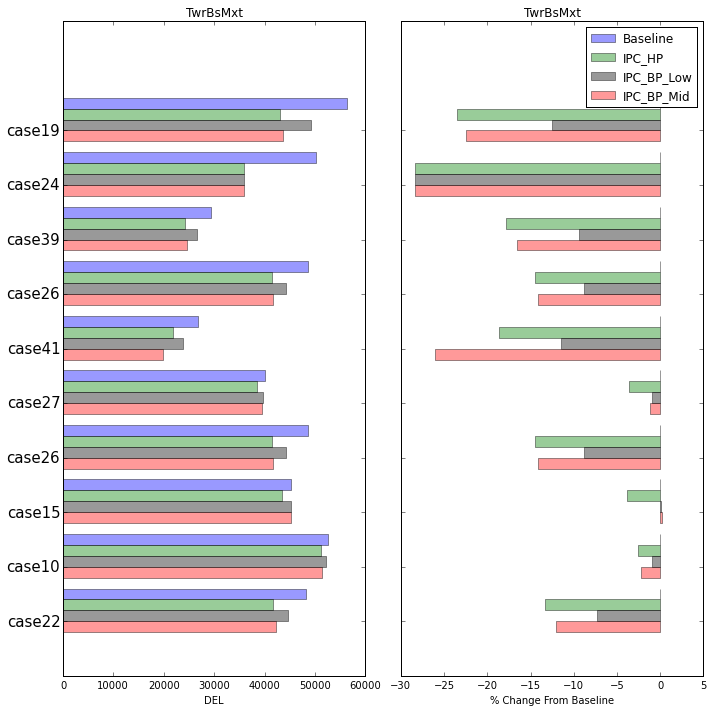

In [47]:
# Compute DEL table for side-side
signalName = 'TwrBsMxt'
m = 4.
calc = 'DEL'
kpiCompare()

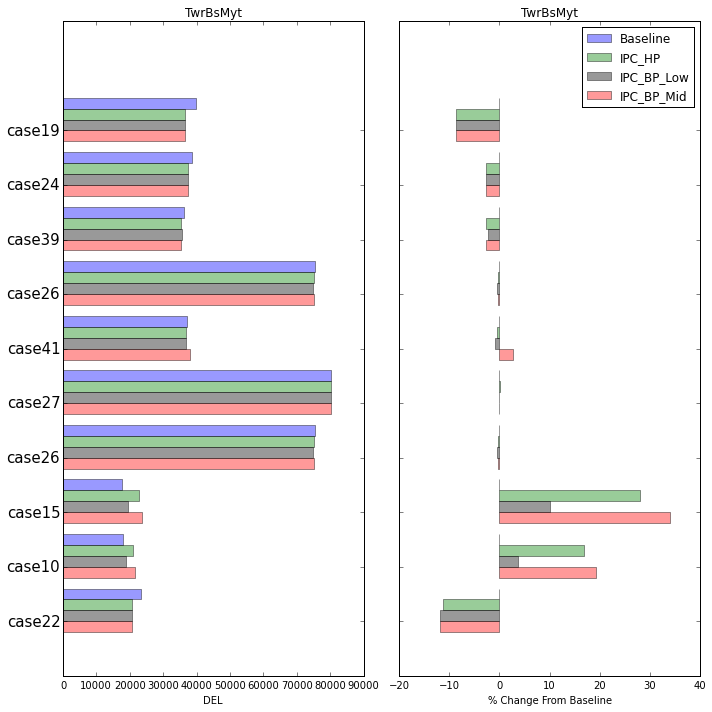

In [48]:
# Compute DEL table for fore-aft
signalName = 'TwrBsMyt'
m = 4.
calc = 'DEL'
kpiCompare()

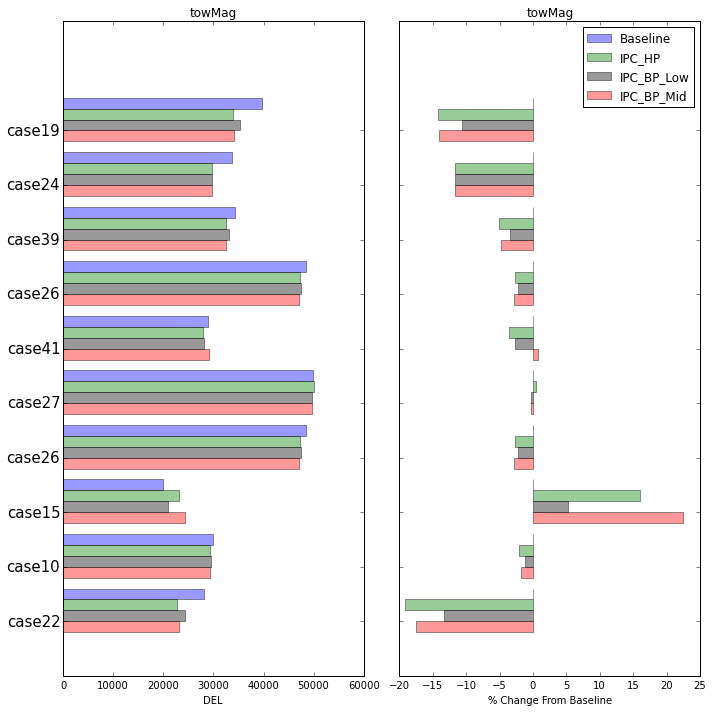

In [49]:
# Compute DEL table for tower mag
signalName = 'towMag'
m = 4.
calc = 'DEL'
kpiCompare()

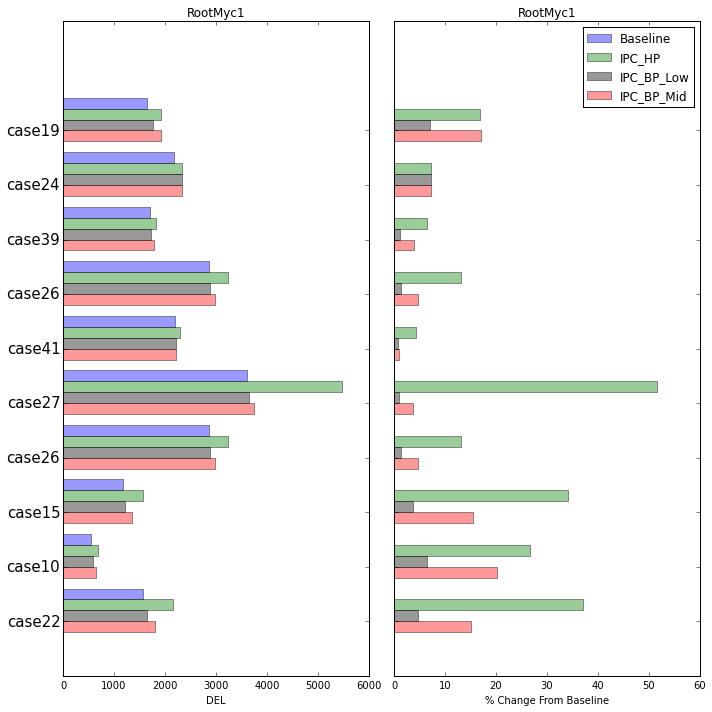

In [50]:
# Compute DEL table out-plange
signalName = 'RootMyc1'
m = 10.
calc = 'DEL'
kpiCompare()

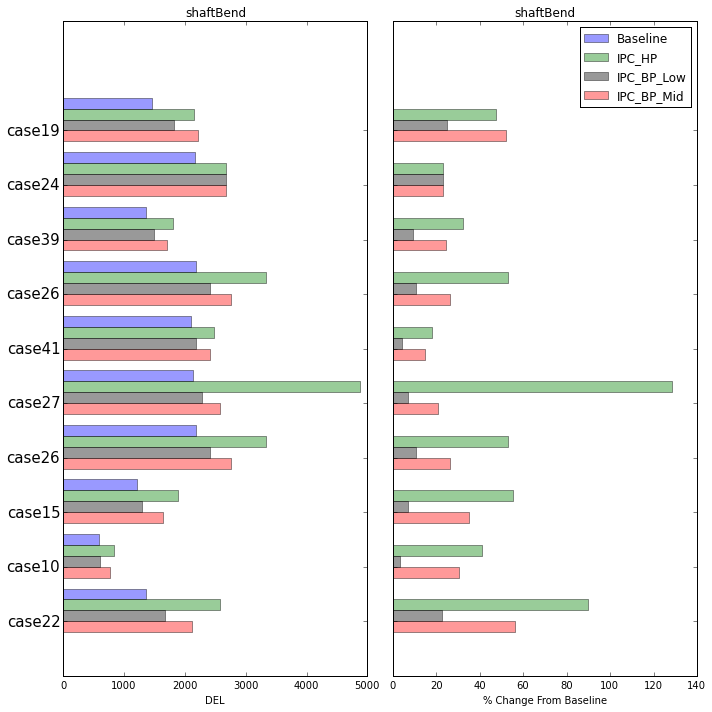

In [51]:
# Compute DEL shaft bending
signalName = 'shaftBend'
m = 4.
calc = 'DEL'
kpiCompare()

In [ ]:
# Compute DEL rotor torque
signalName = 'RotTorq'
m = 4.
calc = 'DEL'
kpiCompare()

In [43]:
# Compute DEL table in-plange
signalName = 'RootMxc1'
m = 10.
calc = 'DEL'
kpiCompare()

KeyError: 'RootMxc1'

In [ ]:
# Compute STD platform rolling
signalName = 'PtfmRoll'
m = 4.
calc = 'STD'
kpiCompare()

In [ ]:
# Compute STD platform pitching
signalName = 'PtfmPitch'
m = 4.
calc = 'STD'
kpiCompare()